# Lasso Logistic Regression Model - Loan Payback Prediction

A regularized logistic regression model with L1 penalty (Lasso) for interpretable loan payback predictions.

**Advantages:**
- Interpretable coefficients
- Enforces intuitive relationships (monotonic by design)
- Fast inference
- Good for interactive apps


In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


## 1) Load feature-engineered data


In [2]:
DATA_DIR = '../data/processed'
TRAIN_FE = os.path.join(DATA_DIR, 'train_fe.csv')
TEST_FE = os.path.join(DATA_DIR, 'test_fe.csv')

train_df = pd.read_csv(TRAIN_FE)
test_df = pd.read_csv(TEST_FE)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['loan_paid_back'].value_counts(normalize=True))
train_df.head()


Train shape: (593994, 22)
Test shape: (254569, 21)

Target distribution:
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,grade,subgrade_num,grade_score,has_stable_income,is_unemployed,loan_to_income_ratio,estimated_monthly_payment,payment_burden,risk_score
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,C,3,4,1,0,0.086094,28.802918,0.011769,0.2207
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,D,3,3,1,0,0.207757,49.452377,0.026842,0.2952
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,C,5,4,1,0,0.343080,138.308553,0.033485,0.1946
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,F,1,1,1,0,0.099929,62.823273,0.016089,0.2260
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,D,1,3,1,0,0.477883,103.669192,0.048792,0.1551


## 2) Prepare features for logistic regression


In [3]:
target = 'loan_paid_back'

# Separate features
categorical_features = [
    'gender', 'marital_status', 'education_level', 'employment_status',
    'loan_purpose', 'grade', 'grade_subgrade'
]

numerical_features = [
    'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate',
    'subgrade_num', 'grade_score', 'has_stable_income', 'is_unemployed',
    'risk_score'
]

feature_cols = categorical_features + numerical_features

X_train = train_df[feature_cols].copy()
y_train = train_df[target].copy()
X_test = test_df[feature_cols].copy()

print(f"Total features: {len(feature_cols)}")
print(f"Categorical: {len(categorical_features)}")
print(f"Numerical: {len(numerical_features)}")
print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Total features: 17
Categorical: 7
Numerical: 10

Train shape: (593994, 17)
Test shape: (254569, 17)


## 3) Create preprocessing pipeline


In [4]:
# Create preprocessing pipeline
# One-hot encode categoricals, standardize numericals
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Fit on training data to get feature names
preprocessor.fit(X_train)

# Get feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = list(cat_feature_names) + numerical_features

print(f"Total features after preprocessing: {len(all_feature_names)}")
print(f"Sample feature names: {all_feature_names[:10]}")


Total features after preprocessing: 64
Sample feature names: ['gender_Male', 'gender_Other', 'marital_status_Married', 'marital_status_Single', 'marital_status_Widowed', 'education_level_High School', "education_level_Master's", 'education_level_Other', 'education_level_PhD', 'employment_status_Retired']


## 4) Train Lasso Logistic Regression with Cross-Validation


In [5]:
# Cross-validation setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Test different C values (inverse of regularization strength)
# Lower C = more regularization (more sparse coefficients)
C_values = [0.01, 0.1, 1.0, 10.0]
best_C = None
best_cv_score = 0
cv_results = []

print(f"Testing {len(C_values)} different C values with {n_splits}-fold CV...")
print("=" * 60)

for C in C_values:
    cv_scores = []
    
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        # Preprocess
        X_tr_processed = preprocessor.transform(X_tr)
        X_val_processed = preprocessor.transform(X_val)
        
        # Train model
        model = LogisticRegression(
            penalty='l1',
            C=C,
            solver='liblinear',  # Works well with L1 penalty
            max_iter=1000,
            class_weight='balanced',  # Handle imbalanced data
            random_state=42
        )
        model.fit(X_tr_processed, y_tr)
        
        # Predict
        val_pred = model.predict_proba(X_val_processed)[:, 1]
        val_auc = roc_auc_score(y_val, val_pred)
        cv_scores.append(val_auc)
    
    mean_auc = np.mean(cv_scores)
    std_auc = np.std(cv_scores)
    
    cv_results.append({
        'C': C,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'scores': cv_scores
    })
    
    print(f"C={C:6.2f} | Mean AUC: {mean_auc:.6f} ± {std_auc:.6f}")
    
    if mean_auc > best_cv_score:
        best_cv_score = mean_auc
        best_C = C

print("=" * 60)
print(f"\nBest C: {best_C} with CV AUC: {best_cv_score:.6f}")


Testing 4 different C values with 5-fold CV...
C=  0.01 | Mean AUC: 0.910905 ± 0.000756
C=  0.10 | Mean AUC: 0.910932 ± 0.000781
C=  1.00 | Mean AUC: 0.910919 ± 0.000782
C= 10.00 | Mean AUC: 0.910917 ± 0.000781

Best C: 0.1 with CV AUC: 0.910932


## 5) Train final model on full dataset


In [6]:
# Preprocess full training data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Train final model with best C
print(f"Training final model with C={best_C}...")
final_model = LogisticRegression(
    penalty='l1',
    C=best_C,
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train_processed, y_train)

print("Model trained successfully!")
print(f"Number of features: {len(final_model.coef_[0])}")
print(f"Number of non-zero coefficients: {np.sum(final_model.coef_[0] != 0)}")
print(f"Sparsity: {(1 - np.sum(final_model.coef_[0] != 0) / len(final_model.coef_[0])) * 100:.2f}%")


Training final model with C=0.1...
Model trained successfully!
Number of features: 64
Number of non-zero coefficients: 54
Sparsity: 15.62%


## 6) Feature importance (coefficients)


Top 20 Most Important Features:


,feature,coefficient
9,employment_status_Retired,3.823961
61,has_stable_income,1.102595
56,credit_score,0.882878
24,grade_F,0.488469
20,grade_B,0.291752
23,grade_E,0.226377
8,education_level_PhD,0.219348
58,interest_rate,0.187458
53,grade_subgrade_F5,0.164147
48,grade_subgrade_E5,0.157914



Bottom 20 Features (negative coefficients):


,feature,coefficient
50,grade_subgrade_F2,-0.023875
2,marital_status_Married,-0.024515
59,subgrade_num,-0.028214
51,grade_subgrade_F3,-0.034615
4,marital_status_Widowed,-0.035000
0,gender_Male,-0.042637
42,grade_subgrade_D4,-0.043398
37,grade_subgrade_C4,-0.045697
1,gender_Other,-0.065158
21,grade_C,-0.075817


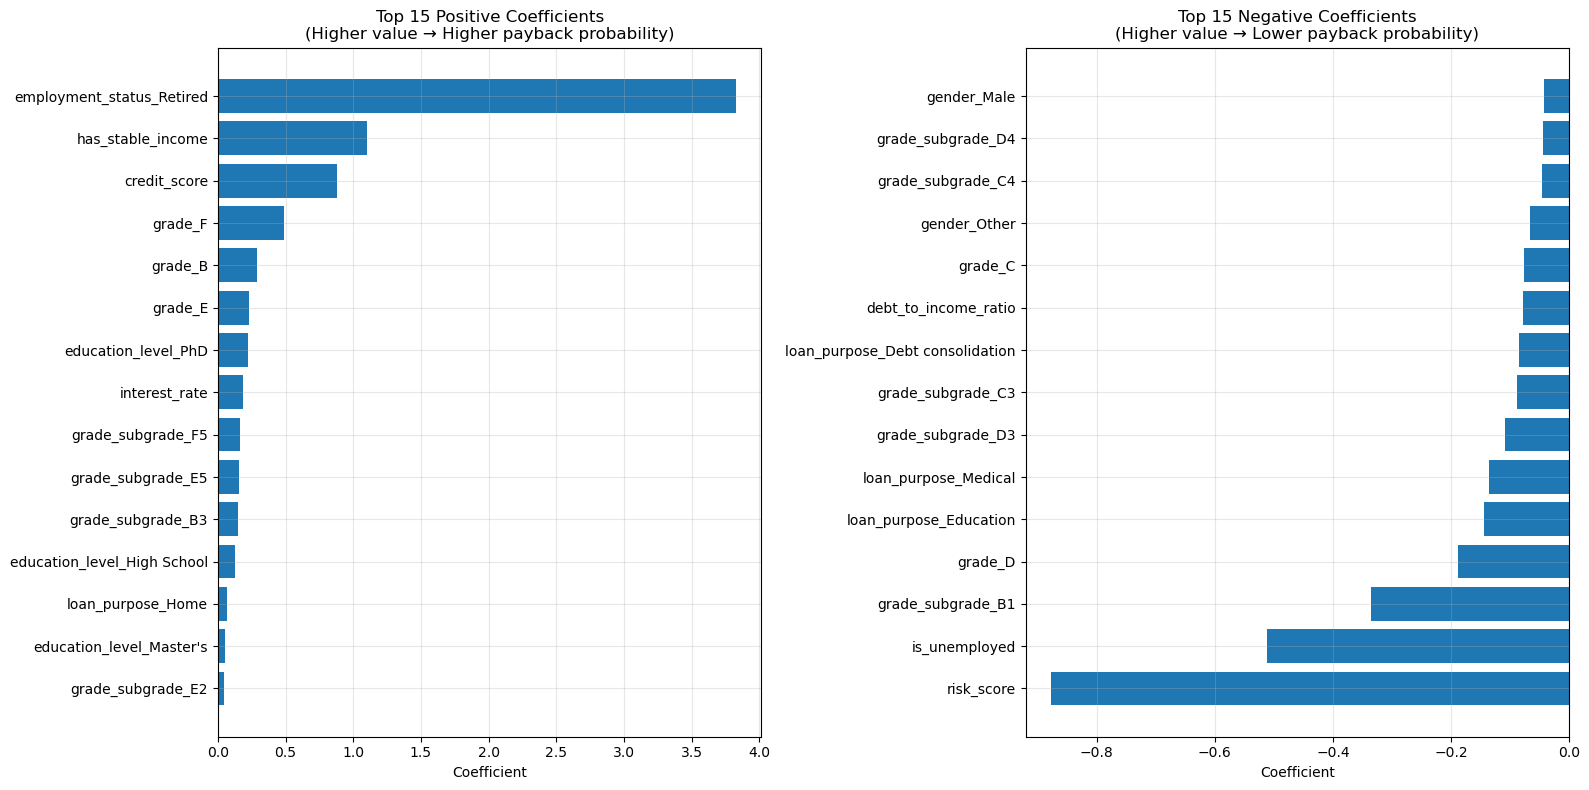


Key Features Analysis:
debt_to_income_ratio          :  -0.0775
credit_score                  :   0.8829
interest_rate                 :   0.1875
has_stable_income             :   1.1026
risk_score                    :  -0.8770


In [7]:
# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': final_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 60)
display(feature_importance.head(20))

print("\nBottom 20 Features (negative coefficients):")
print("=" * 60)
display(feature_importance.tail(20))

# Visualize top features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top positive coefficients
top_positive = feature_importance.head(15)
axes[0].barh(range(len(top_positive)), top_positive['coefficient'].values)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive['feature'].values)
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top 15 Positive Coefficients\n(Higher value → Higher payback probability)')
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis()

# Top negative coefficients
top_negative = feature_importance.tail(15)
axes[1].barh(range(len(top_negative)), top_negative['coefficient'].values)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative['feature'].values)
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Top 15 Negative Coefficients\n(Higher value → Lower payback probability)')
axes[1].grid(True, alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Check key features
print("\nKey Features Analysis:")
print("=" * 60)
key_features = [f for f in all_feature_names if 'interest_rate' in f or 
                'credit_score' in f or 'debt_to_income' in f or 
                'risk_score' in f or 'has_stable_income' in f]
for feat in key_features:
    if feat in feature_importance['feature'].values:
        coef = feature_importance[feature_importance['feature'] == feat]['coefficient'].values[0]
        print(f"{feat:30s}: {coef:8.4f}")


## 7) Save model and preprocessor


In [8]:
# Save model and preprocessor together
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)

model_data = {
    'model': final_model,
    'preprocessor': preprocessor,
    'feature_names': all_feature_names,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'best_C': best_C,
    'cv_score': best_cv_score
}

MODEL_PATH = os.path.join(MODEL_DIR, 'lasso_logistic_model.pkl')
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"Model saved to: {MODEL_PATH}")
print(f"\nModel components saved:")
print(f"  - Logistic Regression model")
print(f"  - Preprocessor (OneHotEncoder + StandardScaler)")
print(f"  - Feature names")
print(f"  - Best C parameter: {best_C}")
print(f"  - CV AUC: {best_cv_score:.6f}")


Model saved to: ../models/lasso_logistic_model.pkl

Model components saved:
  - Logistic Regression model
  - Preprocessor (OneHotEncoder + StandardScaler)
  - Feature names
  - Best C parameter: 0.1
  - CV AUC: 0.910932


## 8) Generate predictions and save submission


In [9]:
# Generate predictions on test set
test_preds = final_model.predict_proba(X_test_processed)[:, 1]

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'loan_paid_back': test_preds
})

RESULTS_PATH = '../results/lasso_regression_submission.csv'
os.makedirs('../results', exist_ok=True)
submission.to_csv(RESULTS_PATH, index=False)

print(f"Submission saved to: {RESULTS_PATH}")
print("\nSubmission preview:")
print(submission.head(10))
print("\nSubmission statistics:")
print(submission['loan_paid_back'].describe())


Submission saved to: ../results/lasso_regression_submission.csv

Submission preview:
       id  loan_paid_back
0  593994        0.774440
1  593995        0.923916
2  593996        0.034982
3  593997        0.754741
4  593998        0.891134
5  593999        0.872982
6  594000        0.923192
7  594001        0.896422
8  594002        0.732490
9  594003        0.004440

Submission statistics:
count    254569.000000
mean          0.658205
std           0.308479
min           0.000023
25%           0.510288
50%           0.770832
75%           0.896974
max           0.999868
Name: loan_paid_back, dtype: float64


## 9) Model Summary

Compare with LightGBM performance and note the interpretability advantages.


In [10]:
print("=" * 60)
print("LASSO LOGISTIC REGRESSION MODEL SUMMARY")
print("=" * 60)
print(f"\nPerformance:")
print(f"  Best C parameter: {best_C}")
print(f"  CV Mean AUC: {best_cv_score:.6f}")

# Find std_auc for best C
best_result = next((r for r in cv_results if r['C'] == best_C), None)
if best_result:
    print(f"  CV Std AUC: {best_result['std_auc']:.6f}")

print(f"\nModel Characteristics:")
print(f"  Total features: {len(all_feature_names)}")
print(f"  Non-zero coefficients: {np.sum(final_model.coef_[0] != 0)}")
print(f"  Sparsity: {(1 - np.sum(final_model.coef_[0] != 0) / len(final_model.coef_[0])) * 100:.2f}%")

print(f"\nAdvantages:")
print(f"  ✓ Fully interpretable coefficients")
print(f"  ✓ Enforces intuitive relationships (monotonic by design)")
print(f"  ✓ Fast inference for interactive apps")
print(f"  ✓ Feature selection via L1 regularization")

print(f"\nSaved files:")
print(f"  Model: {MODEL_PATH}")
print(f"  Submission: {RESULTS_PATH}")
print("=" * 60)


LASSO LOGISTIC REGRESSION MODEL SUMMARY

Performance:
  Best C parameter: 0.1
  CV Mean AUC: 0.910932
  CV Std AUC: 0.000781

Model Characteristics:
  Total features: 64
  Non-zero coefficients: 54
  Sparsity: 15.62%

Advantages:
  ✓ Fully interpretable coefficients
  ✓ Enforces intuitive relationships (monotonic by design)
  ✓ Fast inference for interactive apps
  ✓ Feature selection via L1 regularization

Saved files:
  Model: ../models/lasso_logistic_model.pkl
  Submission: ../results/lasso_regression_submission.csv
